In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import json

import numpy as np
from qiskit import transpile
from qiskit_ibm_runtime import Session, Estimator, QiskitRuntimeService, Options
from qiskit.quantum_info import Operator, Statevector

from nonlocalgames.hamiltonians import G14
from nonlocalgames.circuit import NLGCircuit, load_adapt_ansatz
from nonlocalgames.measurement import MeasurementLayer

2023-09-19 11:37:15,040	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [4]:
def get_pcc() -> Operator:
    proj = 0
    for c in range(4):
        s = f'{c:02b}'[::-1]
        s = s + s
        cc = Statevector.from_label(s)
        pcc = cc.to_operator()
        proj += pcc
    
    return proj

def load_g14_circuit(path: str):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    qubits = 2
    players = 2
    qc = load_adapt_ansatz(
        data['state'],
        '++++',
        [qubits] * players,
        adapt_order=False,
        min_theta = 1e-4)

    # Don't need to transform phi since qinfo's Ry gate follows the qiskit convention
    phi = np.array(data['phi'])

    constrained = False
    if 'constrained' in path:
        constrained = True

    if 'metadata' in data:
        layer = data['metadata'].get('layer', 'ry')
        constrained = data['metadata'].get('constrain_phi', constrained)
    else:
        layer = 'ry'
    
    ml = MeasurementLayer.get(layer, players=2, questions=14, qubits=2)
    
    if constrained:
        if phi.ndim == 1:
            phi = np.concatenate([phi, phi]).reshape(ml.shape)
        else:
            phi = np.concatenate([phi, phi])
            assert phi.shape == ml.shape
    
    ml.params = phi

    if constrained:
        ml.conj(1)

    return qc, ml

In [5]:
qc, ml = load_g14_circuit('../../data/g14_constrained_u3ry/g14_state.json')
nlg = NLGCircuit(qc, None, measurement_layer=ml)

vertices = [(v, v) for v in range(14)]
edges = G14._get_graph().edge_links.tolist()
questions = vertices + edges

pcc = get_pcc()
pcc.dim

(16, 16)

In [6]:
import tqdm

options = Options()
options.execution.shots = 1024
options.optimization_level = 3
options.resilience_level = 2  # ZNE
options.resilience.noise_factors = [1, 2, 3, 4, 5]
# options.resilience.noise_amplifier = "LocalFoldingAmplifier"

dev = 'ibm_hanoi'
service = QiskitRuntimeService(name='full')
backend = service.get_backend(dev)

## Run Estimator on IBM Cloud

In [ ]:
with Session(service=service, backend=backend) as session:
    nlg.backend = backend
    estimator = Estimator(session=session, options=options)
    circuits = []
    for q in tqdm.tqdm(questions):
        circuit = nlg._prepare_question(q)
        circuit.remove_final_measurements()
        print(circuit.metadata)
        circuits.append(circuit)
    
    observables = [pcc] * len(circuits)

    job = estimator.run(circuits=circuits, observables=observables)
    print('Job:', job.job_id())
    result = job.result()

In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(name='full')
job = service.job('ck0tc04iifjafct7hplg')
result = job.result()
backend = job.backend()
dev = backend.name

In [8]:
basepath = 'zne_results_optim{optim}_zne{zne}_{dev}'.format(
            optim=options.optimization_level,
            zne=options.resilience_level,
            dev=dev
        )
metadata = result.metadata
values = result.values.tolist()
for m, q in zip(metadata, questions):
    m['question'] = q
with open(f'{basepath}.json', 'w', encoding='utf-8') as f:
    json.dump({
        'metadata': result.metadata,
        'values': result.values.tolist()
    }, f)

In [9]:
import pandas as pd

records = []

for m, zne_value in zip(metadata, values):
    zne_data = m['zne']['noise_amplification']
    for noise_level, obs_value, obs_var in zip(
        zne_data['noise_factors'],
        zne_data['values'],
        zne_data['variance']):

        records.append({
            'va': m['question'][0],
            'vb': m['question'][1],
            'noise_factor': noise_level,
            'obs_value': obs_value,
            'obs_var': obs_var,
            'extrapolated_value': zne_value
        })

df = pd.DataFrame.from_records(records)
df.sort_values(['va', 'vb'], inplace=True)
df.to_csv(f'{basepath}.csv', index=False)
df

,va,vb,noise_factor,obs_value,obs_var,extrapolated_value
0,0,0,1,0.873047,0.056342,0.942871
1,0,0,2,0.507812,0.127103,0.942871
2,0,0,3,0.976562,0.011508,0.942871
3,0,0,4,0.981445,0.009145,0.942871
4,0,0,5,0.266602,0.186895,0.942871
...,...,...,...,...,...,...
65,13,13,1,0.951172,0.023511,0.447754
66,13,13,2,0.257812,0.187456,0.447754
67,13,13,3,0.222656,0.187225,0.447754
68,13,13,4,0.971680,0.013865,0.447754


## Postprocessing

Results for `ibm_hanoi`

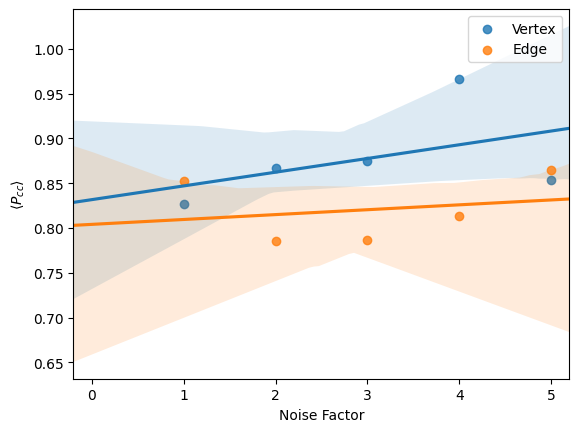

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def process(df):
    df['qtype'] = np.where(df.va == df.vb, 'Vertex', 'Edge')
    df['post_obs_value'] = np.where(
        df.qtype == 'Edge',
        1 - df.obs_value,
        df.obs_value
    )
    df['post_extrapolated_value'] = np.where(
        df.qtype == 'Edge',
        1 - df.extrapolated_value,
        df.extrapolated_value
    )

    return df

dev = 'ibm_hanoi'
df = pd.read_csv(f'zne_results_optim3_zne2_{dev}.csv')
df = process(df)
fig = plt.figure()
ax = fig.gca()
plt.xlim(-0.2, 5.2)
for i, qtype in enumerate(df.qtype.unique()):
    sns.regplot(
        ax=ax,
        data=df.loc[df.qtype == qtype].groupby('noise_factor').mean(numeric_only=True).reset_index(),
        x='noise_factor',
        y='obs_value',
        color=f'C{i}',
        label=qtype,
        marker='o',
        truncate=False
    )
plt.xlabel('Noise Factor')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5])
plt.ylabel(r'$\langle P_{cc} \rangle$')
plt.legend()
plt.show()

We get a much different result using the `simulator_statevector` device..

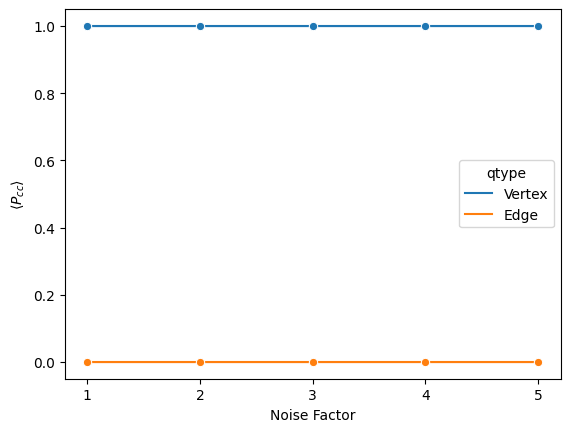

In [15]:
dev = 'simulator_statevector'
df = pd.read_csv(f'zne_results_optim3_zne2_{dev}.csv')

df = process(df)
sns.lineplot(
    data=df,
    x='noise_factor',
    y='obs_value',
    hue='qtype',
    marker='o'
)
plt.xlabel('Noise Factor')
plt.xticks(ticks=[1, 2, 3, 4, 5])
plt.ylabel(r'$\langle P_{cc} \rangle$')
plt.show()

Results for `ibm_auckland`

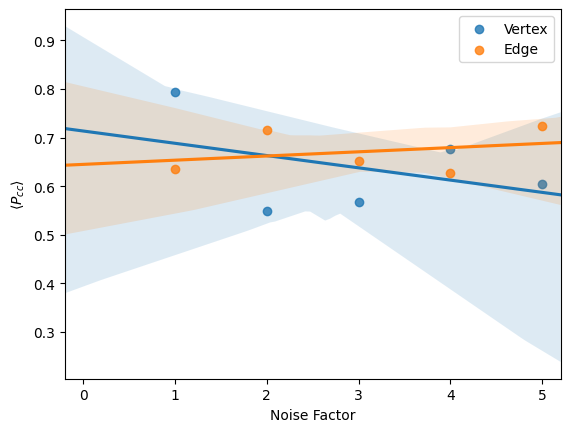

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def process(df):
    df['qtype'] = np.where(df.va == df.vb, 'Vertex', 'Edge')
    df['post_obs_value'] = np.where(
        df.qtype == 'Edge',
        1 - df.obs_value,
        df.obs_value
    )
    df['post_extrapolated_value'] = np.where(
        df.qtype == 'Edge',
        1 - df.extrapolated_value,
        df.extrapolated_value
    )

    return df

dev = 'ibm_auckland'
df = pd.read_csv(f'zne_results_optim3_zne2_{dev}.csv')
df = process(df)
fig = plt.figure()
ax = fig.gca()
plt.xlim(-0.2, 5.2)
for i, qtype in enumerate(df.qtype.unique()):
    sns.regplot(
        ax=ax,
        data=df.loc[df.qtype == qtype].groupby('noise_factor').mean(numeric_only=True).reset_index(),
        x='noise_factor',
        y='obs_value',
        color=f'C{i}',
        label=qtype,
        marker='o',
        truncate=False
    )
plt.xlabel('Noise Factor')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5])
plt.ylabel(r'$\langle P_{cc} \rangle$')
plt.legend()
plt.show()

## Simulating a Noisy Backend

In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import pandas as pd

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler, Estimator
from qiskit_aer.noise import pauli_error, NoiseModel
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider(name='full')
hanoi = provider.get_backend('ibm_hanoi')
basis_gates = hanoi.configuration().basis_gates

def get_noise_model(p_err: float = 0):
    model = NoiseModel()
    error = pauli_error([
        ('I', 1 - p_err),
        ('X', p_err / 2),
        ('Z', p_err / 2)
    ])
    cx_error = error.tensor(error)
    model.add_all_qubit_quantum_error(cx_error, ['cx'])
    return model

records = []
p_err_vals = np.logspace(-4, -1, num=13)
for p_err in tqdm.tqdm_notebook(p_err_vals):
    backend_options = {
        'noise_model': get_noise_model(p_err),
        'coupling_map': hanoi.coupling_map,
        'basis_gates': basis_gates
    }

    run_options = {
        'shots': 1024
    }

    transpile_options = {
        'optimization_level': 3
    }

    # options = Options()
    # options.simulator.set_backend()
    # options.execution.shots = 1024
    # options.optimization_level = 3
    # options.resilience_level = 2  # ZNE
    # options.resilience.noise_factors = [1, 2, 3, 4, 5]

    estimator = Estimator(
        backend_options=backend_options,
        transpile_options=transpile_options,
        run_options=run_options
    )

    circuits = []
    for q in questions:
        circuit = nlg._prepare_question(q)
        circuit.remove_final_measurements()
        circuits.append(circuit)
    
    observables = [pcc] * len(circuits)

    job = estimator.run(circuits=circuits, observables=observables)
    result = job.result()
    for (va, vb), pcc_val in zip(questions, result.values):
        records.append({
            'p_err': p_err,
            'va': va,
            'vb': vb,
            'pcc': pcc_val,
            'p_win': pcc_val if va == vb else 1 - pcc_val
        })

df = pd.DataFrame.from_records(records)
df.to_csv('simulated_noise_hanoi.csv', index=False)
df

  0%|          | 0/13 [00:00<?, ?it/s]

,p_err,va,vb,pcc,p_win
0,0.0001,0,0,1.000000,1.000000
1,0.0001,1,1,0.998047,0.998047
2,0.0001,2,2,0.999023,0.999023
3,0.0001,3,3,0.996094,0.996094
4,0.0001,4,4,0.999023,0.999023
...,...,...,...,...,...
1139,0.1000,8,13,0.194336,0.805664
1140,0.1000,9,13,0.244141,0.755859
1141,0.1000,10,13,0.220703,0.779297
1142,0.1000,11,13,0.193359,0.806641


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.001644951641739589
        x: [ 1.306e-02]
      nit: 6
      jac: [-2.852e-07]
 hess_inv: [[ 1.551e-05]]
     nfev: 24
     njev: 12
[1.76581506]


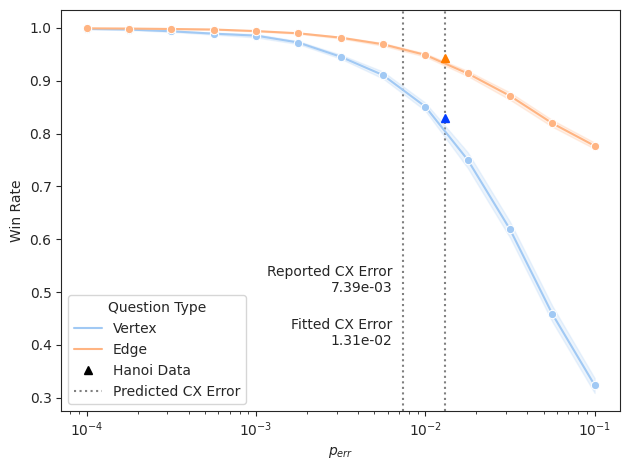

In [54]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('ticks')
sns.set_palette('pastel')

fig = plt.figure()
ax = plt.gca()
df = pd.read_csv('simulated_noise_hanoi.csv')
df['qtype'] = np.where(df.va == df.vb, 'Vertex', 'Edge')
g = sns.lineplot(data=df, x='p_err', y='p_win', hue='qtype',
                 marker='o', ax=ax)

# Plot hanoi data
real_data = pd.read_csv('../../data/g14_constrained_u3ry/ibm_processed.csv')
real_data = real_data.loc[real_data.backend == 'ibm_hanoi', ['qtype', 'q_winrate']]
cx_err = 7.395e-3
# sns.pointplot(data=real_data, x='cx_err', y='q_winrate',
#               hue='qtype', markers='*', ax=ax, scale=2.0)

def get_error_func():
    vertex_df = df.loc[df.qtype == 'Vertex'].copy()
    vertex_df.sort_values('p_err')
    x_v, y_v = vertex_df.p_err.values, vertex_df.p_win.values

    edge_df = df.loc[df.qtype == 'Edge'].copy()
    edge_df.sort_values('p_err')
    x_e, y_e = edge_df.p_err.values, edge_df.p_win.values

    y_v_mean = real_data.loc[real_data.qtype == 'Vertex', 'q_winrate'].mean()
    y_e_mean = real_data.loc[real_data.qtype == 'Edge', 'q_winrate'].mean()

    def error_diff(cx_err):
        pred_y_e = np.interp(cx_err, x_e, y_e)
        pred_y_v = np.interp(cx_err, x_v, y_v)

        dist = (pred_y_e - y_e_mean) ** 2 + (pred_y_v - y_v_mean) ** 2
        return np.sqrt(dist)

    return error_diff

res = minimize(get_error_func(), cx_err)
optimal_cx_err = res.x
print(res)
print(optimal_cx_err / cx_err)

sns.set_palette('bright')

plt.plot(
    optimal_cx_err,
    real_data.loc[real_data.qtype=='Vertex'].q_winrate.mean(),
    '^', color="C0", label='Hanoi Data'
)

plt.plot(
    optimal_cx_err,
    real_data.loc[real_data.qtype=='Edge'].q_winrate.mean(),
    '^', color="C1"
)

ylim = plt.ylim()
plt.vlines(optimal_cx_err, *ylim, label='Predicted CX Error', linestyles='dotted', colors='gray', zorder=-1)
plt.vlines(cx_err, *ylim, linestyles='dotted', colors='gray', zorder=-1)
plt.text(cx_err - 1e-3, 0.5, f'Reported CX Error\n{cx_err:.2e}', horizontalalignment='right')
plt.text(cx_err - 1e-3, 0.4, f'Fitted CX Error\n{optimal_cx_err.item():.2e}', horizontalalignment='right')
plt.ylim(*ylim)

legend = plt.legend()
legend.set_title('Question Type')
legend.get_lines()[2].set_color('black')
plt.xlabel(r'$p_{err}$')
plt.xscale('log')
plt.ylabel('Win Rate')
plt.tight_layout()
plt.savefig('simulated_noise.png', dpi=300)
plt.savefig('simulated_noise.pdf')
plt.show()

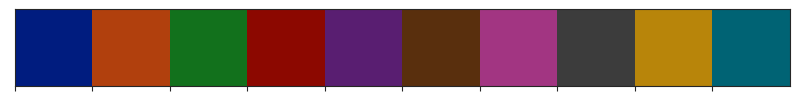

In [42]:
sns.palplot(sns.color_palette('dark'))